In [1]:
import GPy
import copy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (12,7)
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['lines.linewidth'] = 4.0
plt.rcParams['font.size'] = 18.0
plt.rcParams['font.sans-serif'] = 'Helvetica'

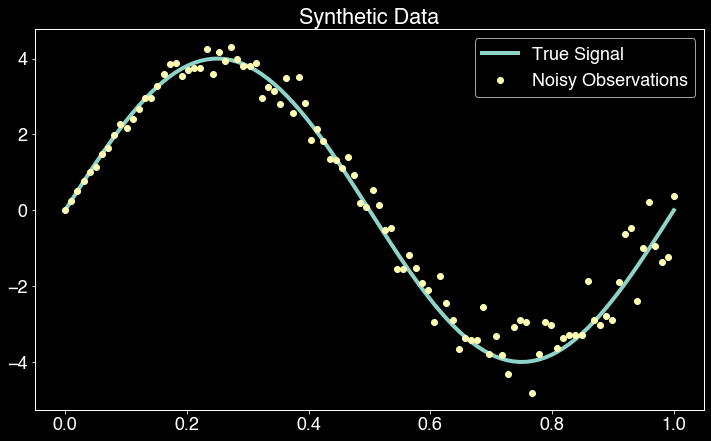

In [3]:
x  = np.linspace(0, 1, 100)
fx = 4.0*np.sin(2.0*np.pi*x)

y = np.zeros(len(x))
for idx,i in enumerate(x):
    y[idx] = 4.0*np.sin(2.0*np.pi*i) + np.random.normal(0.0, i+0.0)

plt.plot(x, fx, label="True Signal")
plt.plot(x, y, 'o', label="Noisy Observations")
plt.title("Synthetic Data")
plt.legend()

# Gaussian Processes GPy 

In [7]:
# RBF and WhiteNoise kernel
kernel1 = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
gp1 = GPy.models.GPRegression(x.reshape(-1,1),y.reshape(-1,1),kernel1)
gp1.optimize(messages=False)
gp1.optimize_restarts(num_restarts = 5)

var_pref = np.zeros((x.shape[0],1))

eps = np.inf
iterations = 0
while ~(eps <= 0.01 or iterations > 10):
    
    m, v = gp1.predict(x.reshape(-1,1))
    s = 10
    variance_noise = np.zeros(len(x))
    for j in range(0, len(x)):
        var = 0.0
        for i in range(0, s):
            var += 0.5 * (y[j] - np.random.normal(m[j], v[j]))**2
        variance_noise[j] = var/s
    z = np.log(variance_noise)

    kernel2 = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
    gp2 = GPy.models.GPRegression(x.reshape(-1,1),z.reshape(-1,1),kernel2)
    gp2.optimize(messages=False)
    gp2.optimize_restarts(num_restarts = 5)
    m_n, v_n = gp2.predict(x.reshape(-1,1))

    kernel3 = GPy.kern.RBF(input_dim=1) + GPy.kern.WhiteHeteroscedastic(input_dim=1, num_data=x.shape[0])
    gp3 = GPy.models.GPRegression(x.reshape(-1,1),y.reshape(-1,1),kernel3)
    gp3.optimize(messages=False)
    gp3.optimize_restarts(num_restarts = 10)
    kernel3.parts[1].variance = np.exp(m_n).reshape(x.shape[0])

    m, v = gp3.predict(x.reshape(-1,1))
    
    diff = var_pref - v
    eps = np.dot(diff.T, diff)[0][0]
    gp1 = copy.deepcopy(gp3)
    var_pref = copy.deepcopy(v)
    print(eps)
    iterations += 1

Optimization restart 1/5, f = 80.55483929120786
Optimization restart 2/5, f = 80.55483929123402
Optimization restart 3/5, f = 80.55483929120433
Optimization restart 4/5, f = 80.55483929131728
Optimization restart 5/5, f = 80.55483929122497
Optimization restart 1/10, f = 131.4105957892795
Optimization restart 2/10, f = 131.410595781334
Optimization restart 3/10, f = 131.41059579938275
Optimization restart 4/10, f = 131.4105957775704
Optimization restart 5/10, f = 131.41059577776204
Optimization restart 6/10, f = 131.41059578456452
Optimization restart 7/10, f = 131.4105957844168
Optimization restart 8/10, f = 131.41059577756533
Optimization restart 9/10, f = 131.4105957793184
Optimization restart 10/10, f = 131.41059577911562
Optimization restart 1/10, f = -20.43321786490184
Optimization restart 2/10, f = -17.544690660528673
Optimization restart 3/10, f = -15.84846397807295
Optimization restart 4/10, f = -16.222852821049187
Optimization restart 5/10, f = -20.543506835305948
Optimization

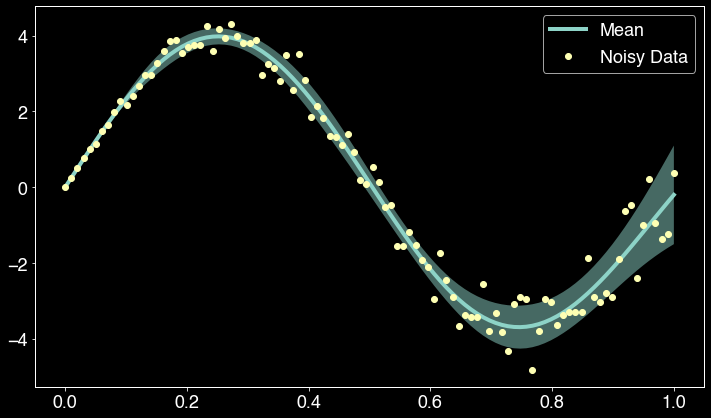

In [11]:
up = m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
dwn = m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))
plt.fill_between(x, up, dwn, alpha=0.5)
plt.plot(x, m, label="Mean")
plt.plot(x, y, 'o', label="Noisy Data")
plt.legend()

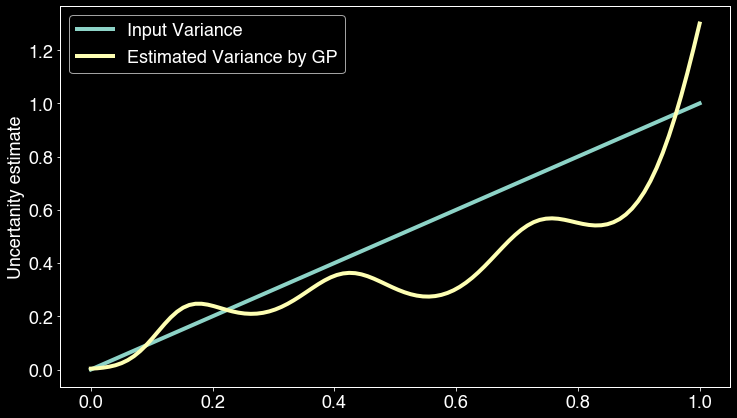

In [12]:
plt.plot(x, x, label="Input Variance")
plt.plot(x, 2.0*np.sqrt(v), label="Estimated Variance by GP")
plt.ylabel("Uncertanity estimate")
plt.legend()

## Things to do

* I am not 100 percent on the optimization being done for the third GP. May be we can use the same hyperparamters from GP1 for the RBF kernel. Kinda makes sense, will confirm its performance once I implement it.